In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
heigh = 256

In [7]:
#get name of image to find mask for it
def get_mask(image):
   return tf.strings.split(image,os.path.sep)[-1]

#load images and masks from path
def process_image_with_mask(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   mask = maskspath + get_mask(file_path)
   mask = tf.io.read_file(mask)
   mask = tf.image.decode_png(mask)
   cond = tf.greater_equal(mask,1)
   mask = tf.where(cond,1,0)
   return img,mask

#load images without masks from path
def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   print(img)
   img = tf.image.resize(img, (heigh, heigh), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   return img

#resize to heigh
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (heigh, heigh), method="nearest")
   input_mask = tf.image.resize(input_mask, (heigh, heigh), method="nearest")
   return input_image, input_mask

#augmentation 1
def flip_leftright(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

#augmentation 2
def flip_updown(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

#augmentation 3
def rotation(input_image, input_mask):
   input_image = tf.image.rot90(input_image)
   input_mask = tf.image.rot90(input_mask)
   return input_image, input_mask

#augmentation 4
def crop(input_image, input_mask):
   seed = random.random()*10000
   input_image = tf.image.random_crop(input_image,size = (heigh*8,heigh*8,3),seed=int(seed))
   input_mask = tf.image.random_crop(input_mask,size = (heigh*8,heigh*8,1),seed=int(seed))
   return input_image, input_mask

def adjust_brightness(input_image, input_mask):
   input_image = tf.image.adjust_brightness(input_image,delta=0.1)
   return input_image, input_mask

def adjust_gamma(input_image, input_mask):
   input_image = tf.image.adjust_gamma(input_image)
   return input_image, input_mask

#normalize mask and image
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.float32)
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(flip_leftright)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(flip_updown)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(adjust_gamma)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(adjust_brightness)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(crop)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
      dataset = dataset.shuffle(64)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [11]:
#unet
#encoder x:
def encoder_x(x,n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

#decoder_x:
def decoder_x(x,skip_connections,n_filters):
    x = tf.keras.layers.concatenate([x,skip_connections])
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

#output
def output(x):
    return tf.keras.layers.Conv2DTranspose(1,3, strides= 2,padding = "same", kernel_initializer = "he_normal",use_bias=False,activation='sigmoid')(x)


def buildmodel():
    inputlayer = tf.keras.layers.Input(shape=(256,256,3))
    print(inputlayer)
    e1 = encoder_x(inputlayer,64)
    e2 = encoder_x(e1,128)
    e3 = encoder_x(e2,256)
    e4 = encoder_x(e3,512)
    e5 = encoder_x(e4,512)
    e6 = encoder_x(e5,512)
    e7 = encoder_x(e6,512)
    x = decoder_x(e7,e7,512)
    x = decoder_x(x,e6,512)
    x = decoder_x(x,e5,512)
    x = decoder_x(x,e4,256)
    x = decoder_x(x,e3,128)
    x = decoder_x(x,e2,64)
    x = tf.keras.layers.concatenate([x,e1])
    outputlayer = output(x)
    print(outputlayer)
    
    unet_model = tf.keras.Model(inputlayer, outputlayer, name="U-Net")

    return unet_model

In [12]:
#dice coef
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return (1 - dice_coef(y_true, y_pred))

def custom_dice_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) * 0.5 + tf.keras.losses.BinaryCrossentropy()(y_true,y_pred)

In [13]:
model = buildmodel()
model.compile(optimizer = 'adam', loss = [custom_dice_loss], metrics = ['accuracy',[dice_coef]])
#tf.keras.utils.plot_model(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [14]:
callback =[tf.keras.callbacks.EarlyStopping(min_delta=0.01,patience=2,verbose=1)
#,tf.keras.callbacks.ModelCheckpoint(filepath='models/model',save_best_only=True,monitor='loss',verbose=1)
]

In [20]:
path = 'castom-masks/ds0/'
imagepath = path + 'img/*'
maskspath = path + 'masks_machine/'


In [21]:
newdata = tf_dataset(imagepath,learning = True)
valdata = tf_dataset(imagepath,learning = True)

In [22]:
len(newdata)

544

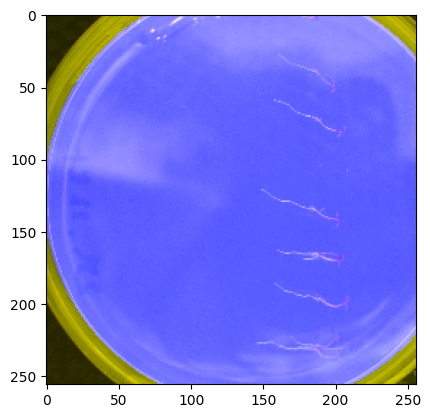

tf.Tensor([], shape=(0,), dtype=float32)


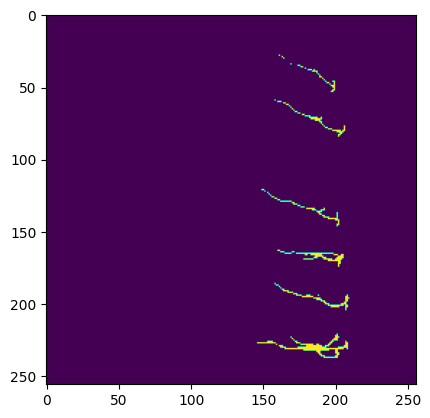

In [23]:
for image,mask in newdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))
        print(mask[mask > 1])

In [24]:
model_history = model.fit(newdata.batch(4),
                              epochs=12,
                              validation_data=valdata,
                              validation_steps=4,
                              callbacks=callback)

Epoch 1/12
 28/136 [=====>........................] - ETA: 1:13 - loss: 1.3412 - accuracy: 0.7216 - dice_coef: 0.0279

KeyboardInterrupt: 

In [26]:
test = tf_dataset('cropped/AAE_0144.png',learning=False)
pred_mask = model.predict(test)

Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)
1/1 [==============================] - 0s 195ms/step


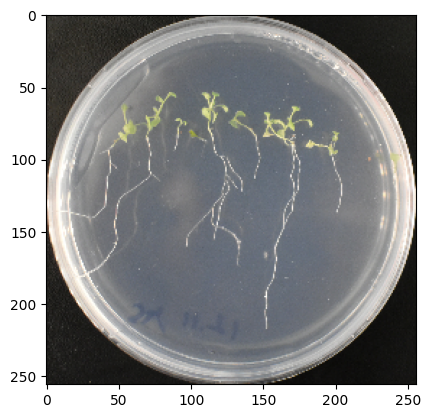

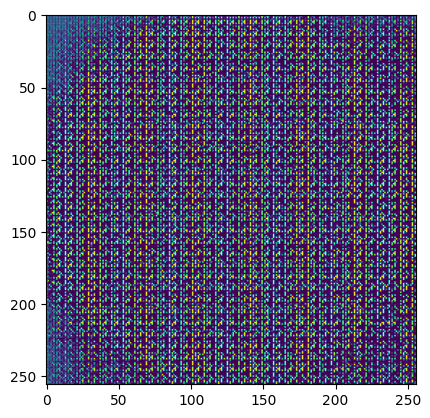

In [27]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])

In [26]:
model.save(filepath='models/model', save_format="h5",overwrite=True)